In [5]:
import os

import keras
import numpy as np
import pandas as pd
# from keras.saving import load_model
from bayesflow.adapters import Adapter

# ---------------- Configuration ----------------
PARAM_NAMES = ['v_base', 'a_init', 't_nd', 'leak', 'collapse_rate']
CHECKPOINT_PATH = './checkpoints_unified_joint/unified_joint_model_behavior_final2.keras'
REAL_DATA_CSV = r'D:\python\mtcode\data1EA\behaviour_eeg_ea\sub02_eeg_behavioral_features.csv'

# ---------------- Load and Prepare Real Data ----------------
df = pd.read_csv(REAL_DATA_CSV)
summary_vars = df[['RT', 'Choice_Correct', 'CPP_Slope', 'N200_Latency']].to_numpy(dtype=np.float32)
summary_vars = summary_vars[~np.isnan(summary_vars).any(axis=1)]
summary_vars = summary_vars.reshape(1, *summary_vars.shape)  # [1, n_trials, n_features]

# ---------------- Rebuild Adapter ----------------
adapter = Adapter() \
    .to_array() \
    .convert_dtype('float64', 'float32') \
    .rename('behavioral_data', 'summary_variables') \
    .concatenate(PARAM_NAMES, into='inference_variables', axis=-1) \
    .standardize('summary_variables') \
    .keep(['summary_variables', 'inference_variables'])

# Adapt real data (simulate what would happen in the workflow)
# conditions = adapter({'summary_variables': summary_vars})

# ---------------- Load Trained Amortizer ----------------
approximator = keras.saving.load_model(CHECKPOINT_PATH)




D:\myanaconda\envs\TORCHGPU3\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 397 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [6]:
# %% Joint Modeling of EEG and Behavioral Data - Unified Model for Two Datasets

import os
import numpy as np
import matplotlib.pyplot as plt
import keras
import torch
import bayesflow as bf

from bayesflow.simulators import make_simulator
from bayesflow.adapters import Adapter
from bayesflow.networks import DeepSet, CouplingFlow
from bayesflow.workflows import BasicWorkflow
from bayesflow.diagnostics.plots import recovery

from pyddm import Model, ICPoint
from pyddm.models import Drift, Noise, Bound, Overlay
from pyddm.models.overlay import OverlayNonDecision

# %% Global Configuration
PARAM_NAMES = ['v_base', 'a_init', 't_nd', 'leak', 'collapse_rate']
N_PARAMS = len(PARAM_NAMES)
N_TRIALS = 200
DT = 0.01
T_DUR = 5.0
NOISE_CONST = 1.0
FIXED_Z = 0.5
# Unified priors based on ACTUAL data statistics from both datasets
#                      [v_base, a_init, z, t_nd, leak, collapse, gamma, sigma_cpp, sigma_n200]

PRIOR_LOWER = np.array([-3.0, 0.7, 0.25, 0.0, 0.0])
PRIOR_UPPER = np.array([3.0, 2.0, 0.45, 2.0, 1.0])

CHECKPOINT_DIR = './checkpoints_unified_joint'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)



# %% Prior Function

def prior():
    """Generate unified prior samples for both datasets"""
    theta = np.random.uniform(PRIOR_LOWER, PRIOR_UPPER).astype(np.float32)
    return dict(zip(PARAM_NAMES, theta))


# %% Custom DDM Components

class DriftLeaky(Drift):
    name = "Leaky Drift"
    required_parameters = ["v_base", "leak"]

    def get_drift(self, x, t, conditions, **kwargs):
        return np.clip(self.v_base - self.leak * x, -8.0, 8.0)


class BoundExpCollapse(Bound):
    name = "Exponential Collapse"
    required_parameters = ["a_init", "collapse_rate"]

    def get_bound(self, t, conditions, **kwargs):
        return np.clip(self.a_init * np.exp(-self.collapse_rate * t), 0.01, 3.0)


class NoiseFixed(Noise):
    name = "Fixed Noise"
    required_parameters = ["noise"]

    def get_noise(self, x, t, conditions, **kwargs):
        return self.noise


# %% Behavioral Data Processing

def fixed_behavioral_data(sol, sample, n):
    """Extract and standardize behavioral data from PyDDM solution"""
    rt_up = np.array(sample.choice_upper)
    rt_lo = np.array(sample.choice_lower)
    rt = np.concatenate([rt_up, rt_lo])
    choice = np.concatenate([np.ones(len(rt_up)), np.zeros(len(rt_lo))])
    total = len(rt)

    # Ensure we have exactly n trials
    while total < n:
        additional_sample = sol.sample(n - total)
        rt_add_up = np.array(additional_sample.choice_upper)
        rt_add_lo = np.array(additional_sample.choice_lower)
        rt_add = np.concatenate([rt_add_up, rt_add_lo])
        choice_add = np.concatenate([np.ones(len(rt_add_up)), np.zeros(len(rt_add_lo))])
        rt = np.concatenate([rt, rt_add])
        choice = np.concatenate([choice, choice_add])
        total = len(rt)

    rt = rt[:n]
    choice = choice[:n]
    return np.stack([rt, choice], axis=1).astype(np.float32)





# %% Likelihood Function - Unified for Both Datasets

def likelihood(v_base, a_init, t_nd, leak, collapse_rate, n_trials=N_TRIALS):
    """Unified likelihood function for both datasets"""

    # Behavioral modeling with PyDDM
    try:
        model = Model(
            drift=DriftLeaky(v_base=v_base, leak=leak),
            noise=NoiseFixed(noise=NOISE_CONST),
            bound=BoundExpCollapse(a_init=a_init, collapse_rate=collapse_rate),
            overlay=OverlayNonDecision(nondectime=t_nd),
            dx=0.01, dt=DT, T_dur=T_DUR
        )

        sol = model.solve()
        samp = sol.sample(n_trials)
        behav = fixed_behavioral_data(sol, samp, n_trials)

    except:
        # Fallback with realistic RT range matching both datasets
        # Dataset A: mean=0.76s, Dataset B: mean=1.35s
        rt = np.random.uniform(0.2, 5.0, n_trials)  # Conservative upper bound

        # Choice proportion between datasets (A: 50.4%, B: 96.4%)
        choice_prob = np.random.uniform(0.5, 0.95)  # Variable choice bias
        choice = np.random.binomial(1, choice_prob, n_trials)
        behav = np.stack([rt, choice], axis=1).astype(np.float32)


    # Quality checks with realistic fallbacks
    if not np.all(np.isfinite(behav)) :
        # Realistic fallback matching EXACT data distributions
        rt = np.random.uniform(0.5, 5.0, n_trials)
        choice = np.random.binomial(1, 0.75, n_trials)  # Between 50.4% and 96.4%
        behav = np.stack([rt, choice], axis=1).astype(np.float32)



    return {'behavioral_data': behav}


# %% Simulator
simulator = make_simulator([prior, likelihood])

# %% Adapter
adapter = Adapter() \
    .to_array() \
    .convert_dtype('float64', 'float32') \
    .rename('behavioral_data', 'summary_variables') \
    .concatenate(PARAM_NAMES, into='inference_variables', axis=-1) \
    .standardize('summary_variables') \
    .keep(['summary_variables', 'inference_variables'])


# %% Networks - Optimized for unified modeling
summary_net = DeepSet(summary_dim=128, num_layers=4)
inference_net = CouplingFlow(
    depth=10,
    input_dim=N_PARAMS,
    subnet='mlp',
    subnet_kwargs={'hidden_units': [128, 128, 64], 'activation': 'elu'},
    permutation='random',
    use_actnorm=True,
    base_distribution='normal'
)

# %% Workflow
workflow = BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    summary_network=summary_net,
    inference_network=inference_net,
    checkpoint_filepath=CHECKPOINT_DIR,
    checkpoint_name="unified_joint_model"
)


# %% Training Functions

def train_unified_model(epochs=2, simulations_per_epoch=10000, learning_rate=5e-5, batch_size=32):
    """Train unified model for both datasets"""

    print("=== Training Unified Joint EEG-Behavioral Model ===")
    print(f"Parameters: epochs={epochs}, lr={learning_rate}, batch_size={batch_size}")
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    history = workflow.fit_online(
        epochs=epochs,
        simulations_per_epoch=simulations_per_epoch,
        batch_size=batch_size,
        optimizer=optimizer,
        show_progress=True
    )

    save_path = f"{CHECKPOINT_DIR}/unified_joint_model_behavior.keras"
    workflow.approximator.save(filepath=save_path, overwrite=True)
    print(f"Unified model saved to {save_path}")

    return history


def run_parameter_recovery(n_recovery=500):
    """Run parameter recovery analysis"""
    print(f"\nRunning Parameter Recovery Analysis...")
    print("=" * 50)

    # Generate recovery data
    recovery_data = workflow.simulator.sample(batch_size=n_recovery)
    adapted = workflow.adapter(recovery_data)

    # Filter valid data
    valid_mask = ~np.isnan(adapted['summary_variables']).any(axis=1)
    valid_idx = np.where(valid_mask)[0]

    if len(valid_idx) == 0:
        print("No valid simulations for parameter recovery!")
        return

    print(f"Valid simulations: {len(valid_idx)}/{n_recovery}")

    true_params = adapted['inference_variables'][valid_idx]
    conditions = {k: v[valid_idx] for k, v in recovery_data.items() if k not in PARAM_NAMES}

    # Sample posteriors
    posteriors = workflow.sample(conditions=conditions, num_samples=1000)
    posterior_array = np.stack([posteriors[k] for k in PARAM_NAMES], axis=-1)

    if posterior_array.ndim == 4 and posterior_array.shape[2] == 1:
        posterior_array = np.squeeze(posterior_array, axis=2)

    # Calculate recovery metrics
    estimates_mean = posterior_array.mean(axis=1)

    print("\nParameter Recovery Results:")
    print("=" * 50)

    recovery_metrics = {}
    for i, name in enumerate(PARAM_NAMES):
        true_vals = true_params[:, i]
        est_vals = estimates_mean[:, i]

        # Correlation
        r = np.corrcoef(true_vals, est_vals)[0, 1] if np.std(true_vals) > 0 else 0.0

        # Bias and RMSE
        bias = np.mean(est_vals - true_vals)
        rmse = np.sqrt(np.mean((est_vals - true_vals) ** 2))

        recovery_metrics[name] = {'correlation': r, 'bias': bias, 'rmse': rmse}

        print(f"{name:>15}: r = {r:>6.3f}, bias = {bias:>7.4f}, RMSE = {rmse:>6.3f}")

    # Create recovery plot
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()

    for i, name in enumerate(PARAM_NAMES):
        ax = axes[i]
        true_vals = true_params[:, i]
        est_vals = estimates_mean[:, i]

        ax.scatter(true_vals, est_vals, alpha=0.6, s=20)

        # Perfect recovery line
        min_val, max_val = true_vals.min(), true_vals.max()
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)

        ax.set_xlabel(f'True {name}')
        ax.set_ylabel(f'Estimated {name}')
        ax.set_title(f'{name} (r = {recovery_metrics[name]["correlation"]:.3f})')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle('Unified Model Parameter Recovery', fontsize=16, y=0.98)
    plt.show()

    return posteriors, true_params, recovery_metrics


# %% Data Distribution Analysis

def analyze_simulated_distributions(n_samples=1000):
    """Analyze simulated data distributions vs real data"""
    print("\nAnalyzing Simulated Data Distributions...")
    print("=" * 50)

    # Generate sample data
    sample_data = workflow.simulator.sample(batch_size=n_samples)

    # Extract data
    behav_data = sample_data['behavioral_data']

    rt_sim = behav_data[:, :, 0].flatten()
    choice_sim = behav_data[:, :, 1].flatten()

    print("SIMULATED DATA STATISTICS (should match real data):")
    print(f"RT: Mean={rt_sim.mean():.3f}s, SD={rt_sim.std():.3f}")
    print(f"RT: Min={rt_sim.min():.3f}, Max={rt_sim.max():.3f}")
    print(f"RT: Target ranges - A: 0.76±0.19s, B: 1.35±0.81s")
    print(f"Choice proportion: {choice_sim.mean():.3f} (target: 0.50-0.96)")




Running parameter recovery analysis with 200 simulations...
Found 200 valid simulations out of 200.


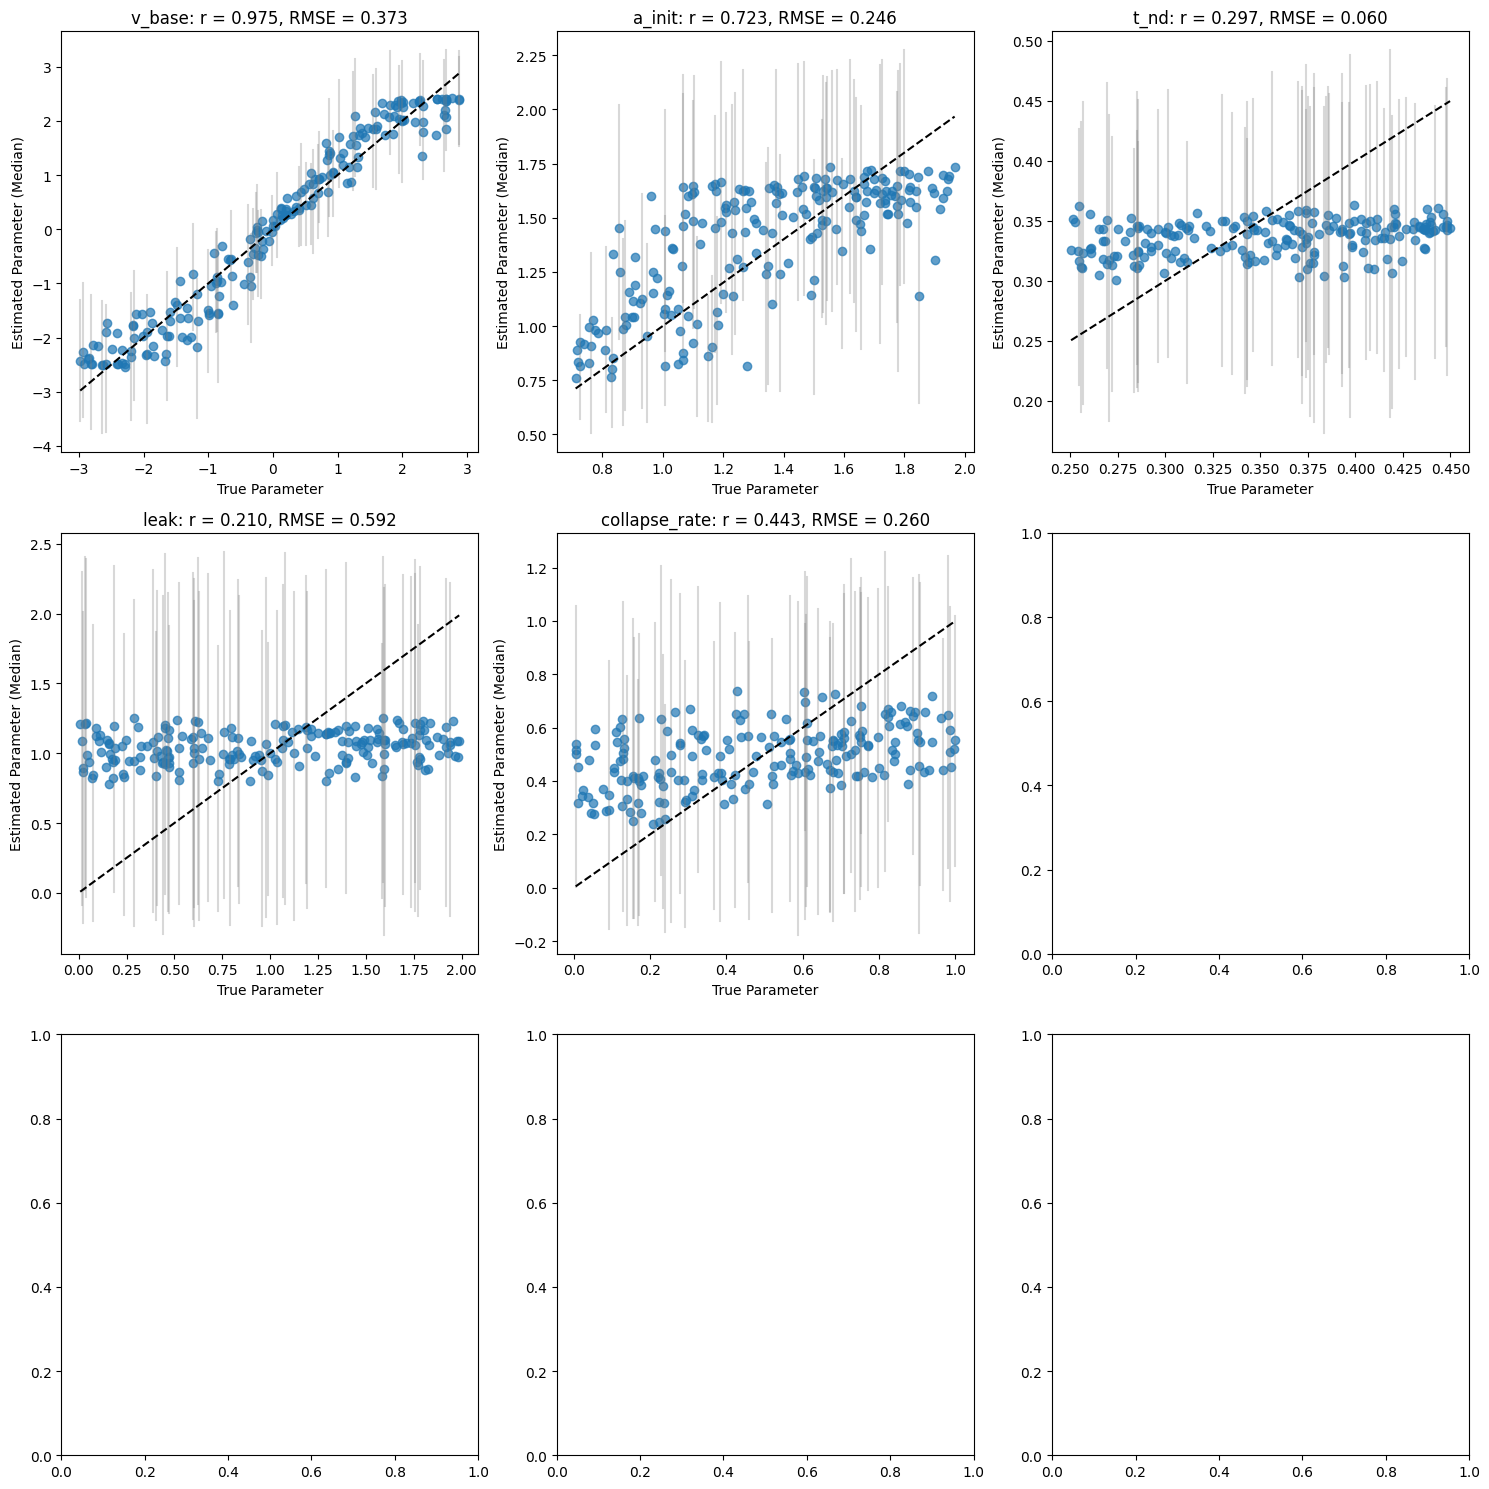


Parameter Recovery Metrics:
Parameter         r (Mean) r (Median)  RMSE (Mean) RMSE (Median) Calib. Err
---------------------------------------------------------------------------
v_base               0.975      0.975        0.374        0.373      0.113
a_init               0.723      0.723        0.246        0.246      0.030
t_nd                 0.306      0.297        0.060        0.060      0.079
leak                 0.212      0.210        0.592        0.592      0.097
collapse_rate        0.446      0.443        0.260        0.260      0.046

Overall Recovery Performance:
Average correlation (r): 0.530
Average RMSE: 0.306
Average calibration error: 0.073


In [7]:
from run_parameter_recovery_analysis import *
metrics = run_parameter_recovery_analysis(
    approximator=approximator,
    simulator=simulator,
    adapter=adapter,
    param_names=PARAM_NAMES,
    n_sims=200  # or more
)